In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from preprocess_lane_lines import *
from visualize_images import *
import ProcessFrame
%matplotlib inline
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Camera calibration

The first procedure was to correct for distortion introduced in images by the camera lens. There are 3 steps in this process.

1. Identifying object points in 3D world co-ordinates of a known 2D object (in this case the corners of a 2D Chessboard pattern). This was done by looking at the chessboard pattern (provided by Udacity) and identifying the number of inside corners in x and y (z is 0 since object can be assumed to be in the center of the world). The object points can then be generated using numpy mgrid which sets up a 3D mesh representing the corners in world co-ordinates.  
2. Detecting corners in multiple camera images of the know object (in this case multiple calibration images of the Chessboard pattern from different angles provided by Udacity). This was achieved using the open CV routine - cv2.findChessboardCorners. The detected corners represent image points in a 2D plane.
3. Computing the calibration matrix and distortion params using the cv2.calibrateCamera routine which takes as inputs the object points and image points. The calibration matrix M represnts the mapping bettwen the 3D object space in world coordinates and 2D image space in image coordinates. The distortion params are a set of distortion co-efficients that correct for radial and tangential distortion. The computed params were pickled for re-use in the pipeline. These params can then be used to calibrate the image using the cv2.undistort() routine.

The `calibrate_images.py` script implements all the steps described above.

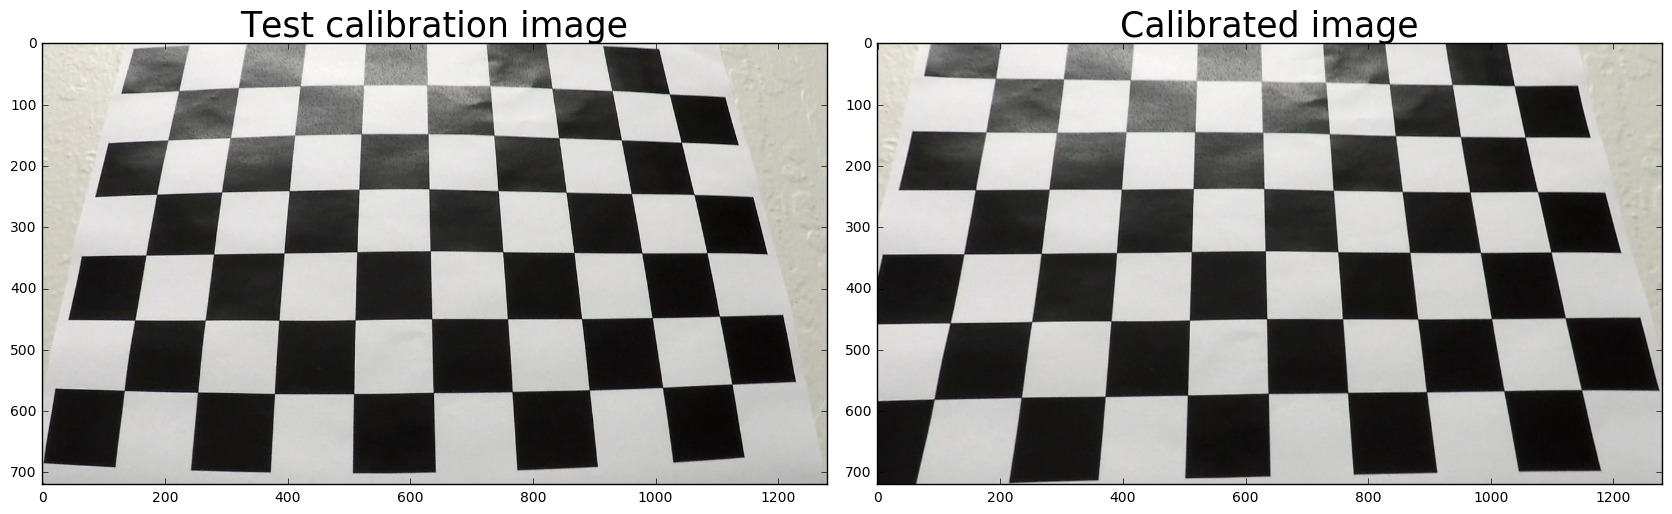

In [2]:
# Test calibration on an image
img = mpimg.imread('./camera_cal/calibration3.jpg')
calib_pickle = pickle.load( open( "data/cam_calib_pickle.p", "rb" ) )
mtx = calib_pickle["mtx"]
dist = calib_pickle["dist"]
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
show_image(img, dst, titles=['Test calibration image', 'Calibrated image'], disp_flag = True)

# Pre-processing

The goal of the pre-processing steps is to produce a binary thresholded image with as much lane information as possible while minimizing the extraneous information. The following pre-processing steps are implemented in the `preprocess_lane_lines.py` script.

## Undistortion:

The pickled values from the camera calibration step described above are applied on the incoming image using the cv2.undistort() routine.
 
 
 
 

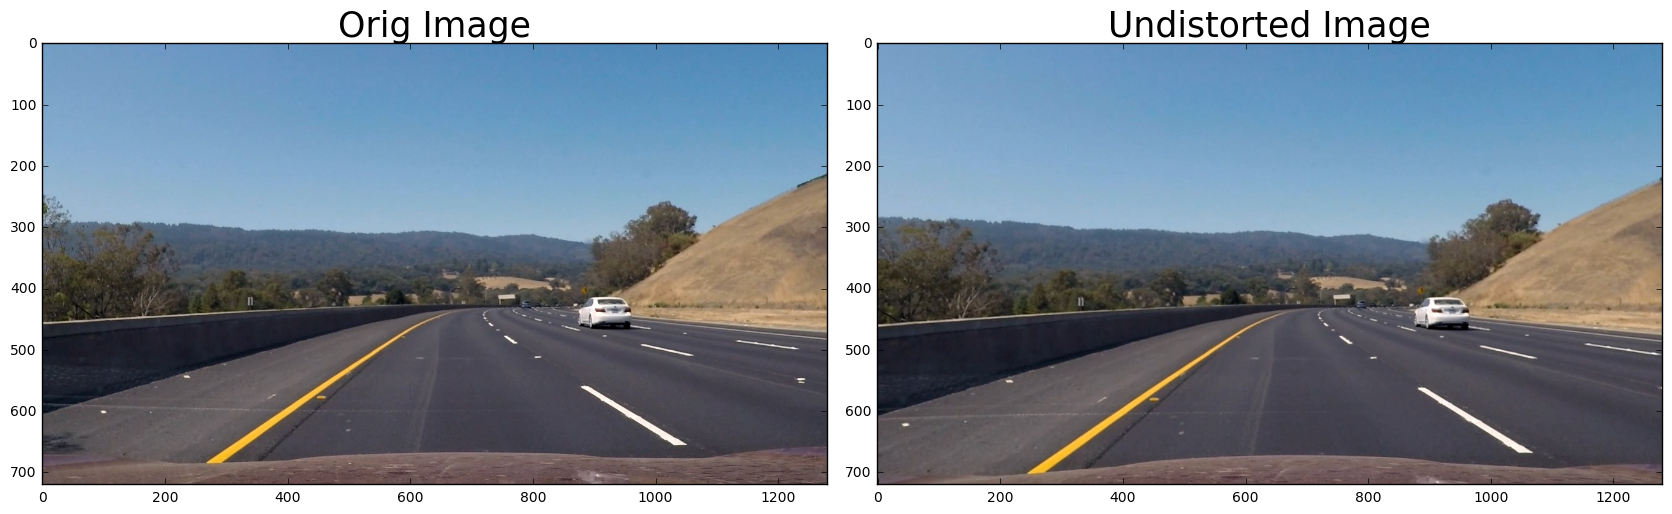

In [3]:
image = mpimg.imread('./test_images/test3.jpg')#test3
#undistort the image
calib_pickle = pickle.load( open( "data/cam_calib_pickle.p", "rb" ) )
mtx = calib_pickle["mtx"]
dist = calib_pickle["dist"]
undist_img = cv2.undistort(image, mtx, dist, None, mtx)
show_image(image, undist_img, titles=['Orig Image', 'Undistorted Image'], disp_flag = True)

The distortion correction is hard to notice until you look near the edges / corners of the corrected image. In this case you can notice that the undistorted image has some of the trees (on the left edge) and a little bit of the hill (on the right edge) is cut off.

## Edge detection: 

Edge detection is performed on the undistorted images by running a sobel operator on the image (using cv2.sobel) in different directions. Computing the gradient in the x-direction has the property of detecting vertical edges and computing the gradient in y direction has the property of detecting horizontal edges.  Suitable thresholds were then applied on the gradient images to try and extract as much of the lane lines as possible while discarding the background. These threshold values were chosen empirically. The resulting images were binary images. I initially performed edge detection on the undistorted RGB images. Later after some experimentation with color spaces (more on this below), I found I could achieve better results by thresholding on the S channel (Saturation channel) of the HLS converted image.

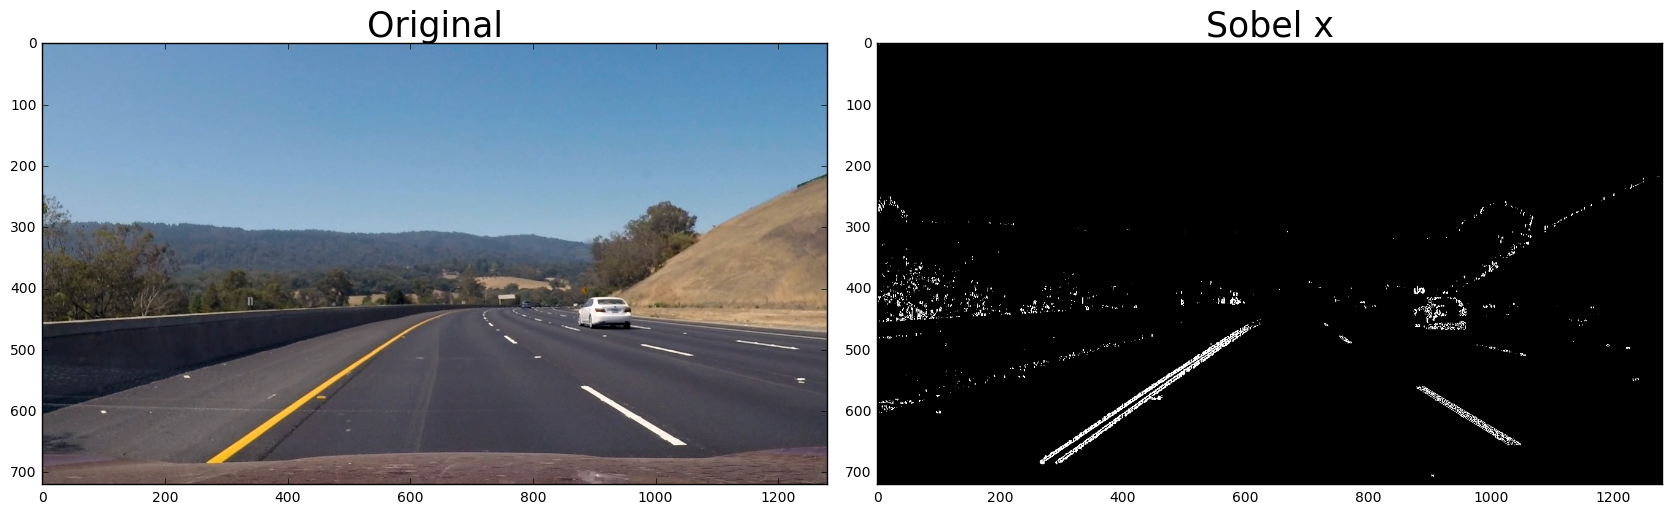

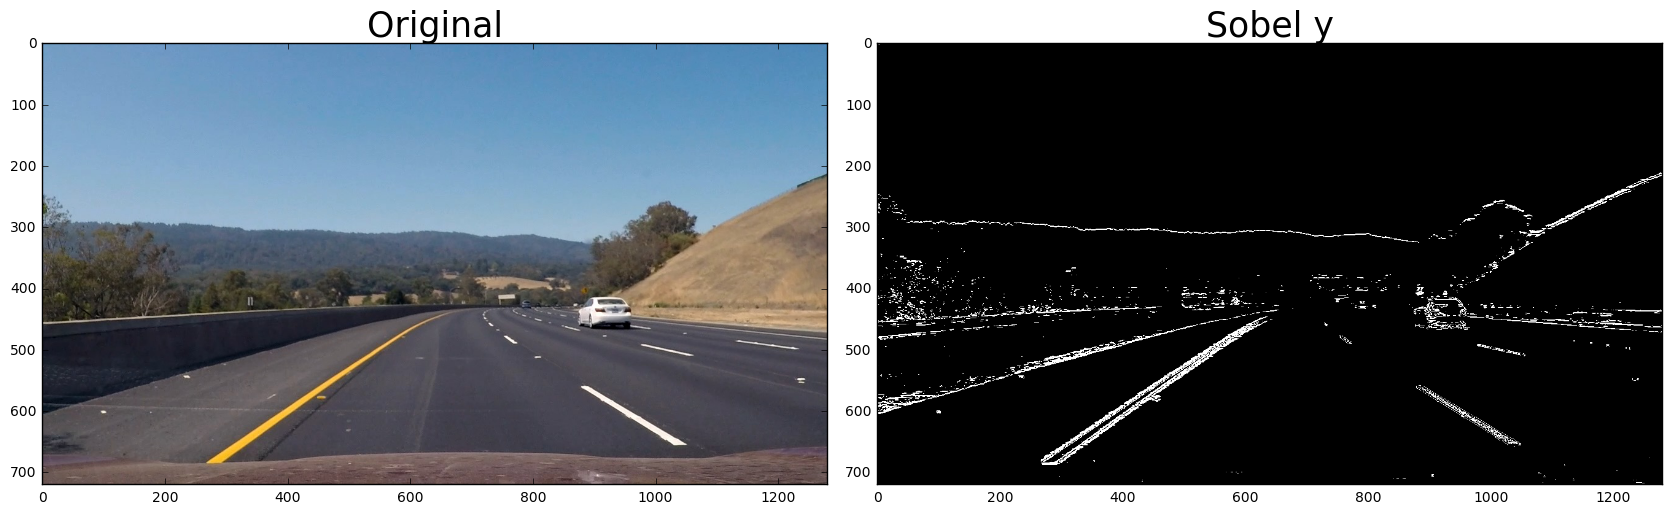

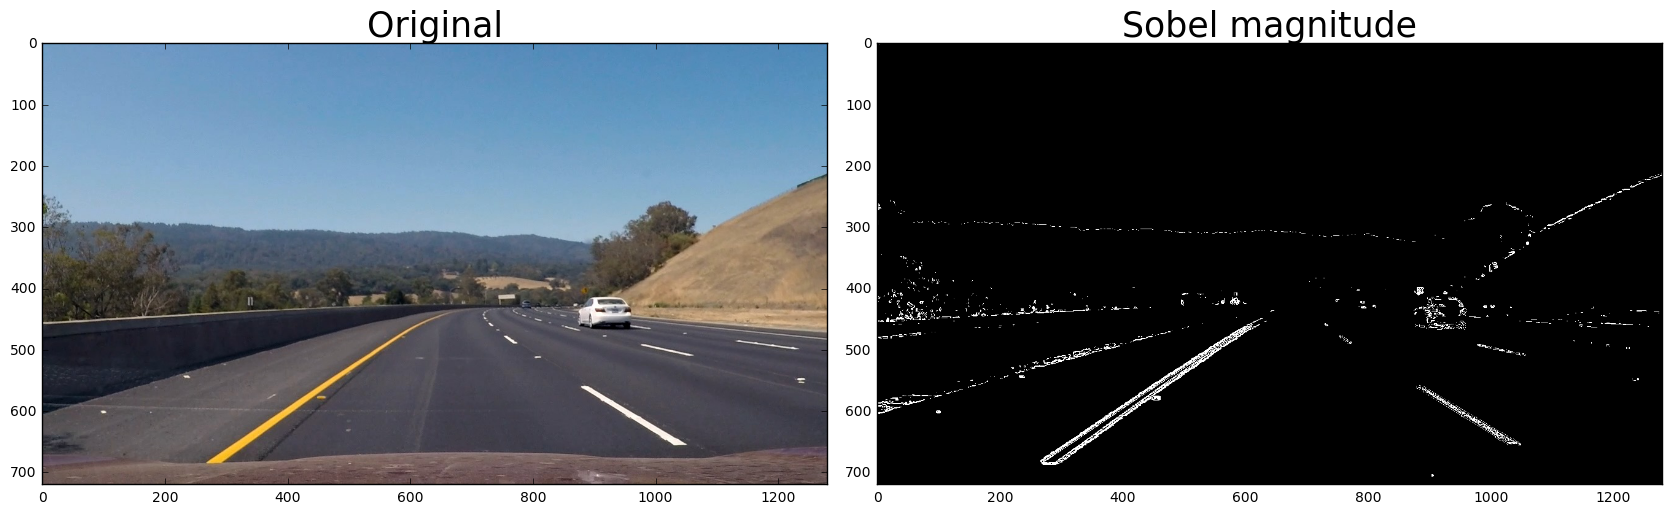

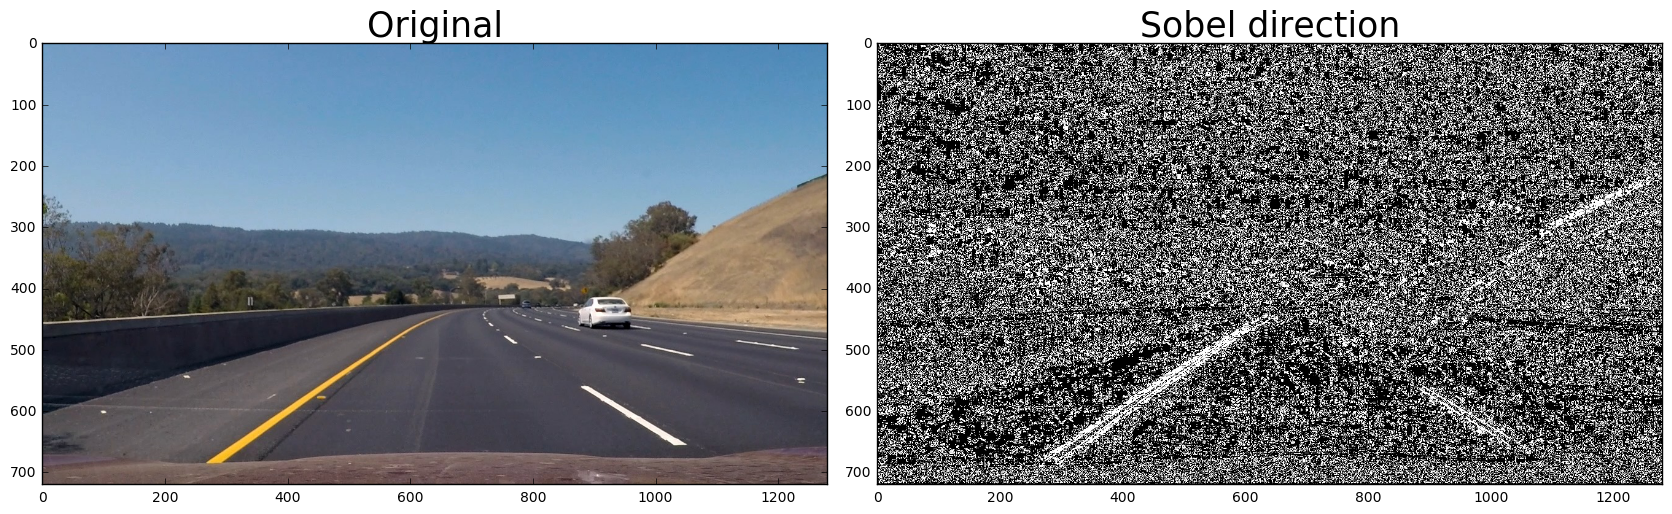

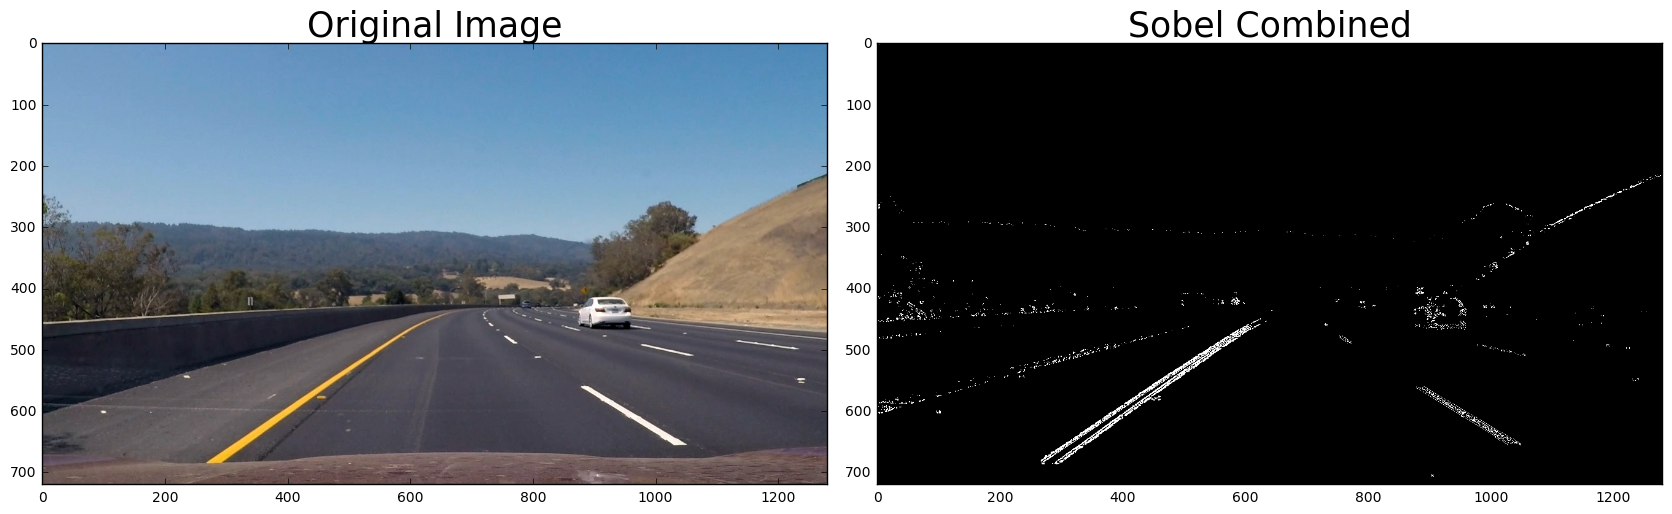

In [4]:
# Choose a Sobel kernel size
ksize = 3

thresh_x, thresh_y, thresh_mag, thresh_dir = (20, 100), (20, 100), (30, 100), (0.7, 1.3)
# Apply sobel ops
gradx, grady, mag_binary, dir_binary = grad_thresh(image, thresh_x, thresh_y, thresh_mag, thresh_dir)
show_image(image, gradx, titles=['Original', 'Sobel x'], disp_flag=True)
show_image(image, grady, titles=['Original', 'Sobel y'], disp_flag=True)
show_image(image, mag_binary, titles=['Original', 'Sobel magnitude'], disp_flag=True)
show_image(image, dir_binary, titles=['Original', 'Sobel direction'], disp_flag=True)

combined_grad_binary = np.zeros_like(dir_binary)
combined_grad_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
show_image(image, combined_grad_binary, titles=['Original Image', 'Sobel Combined'], disp_flag=True)

## Color space conversion:

The undistorted RGB color images were converted to the HLS colorspace (using cv2.cvtColor). Converting to the HLS color space has the effect of separating the brightness from the actual color of the pixels (the Luminance channel encapsulates the brightness while the Hue and Saturation encapsulates the color). This makes it easier to separate out the desired colors. Suitable thresholds were applied to select the yellow and white lines in the HLS images. The thresholds were chosen by playing around with a color picker here http://colorizer.org/.

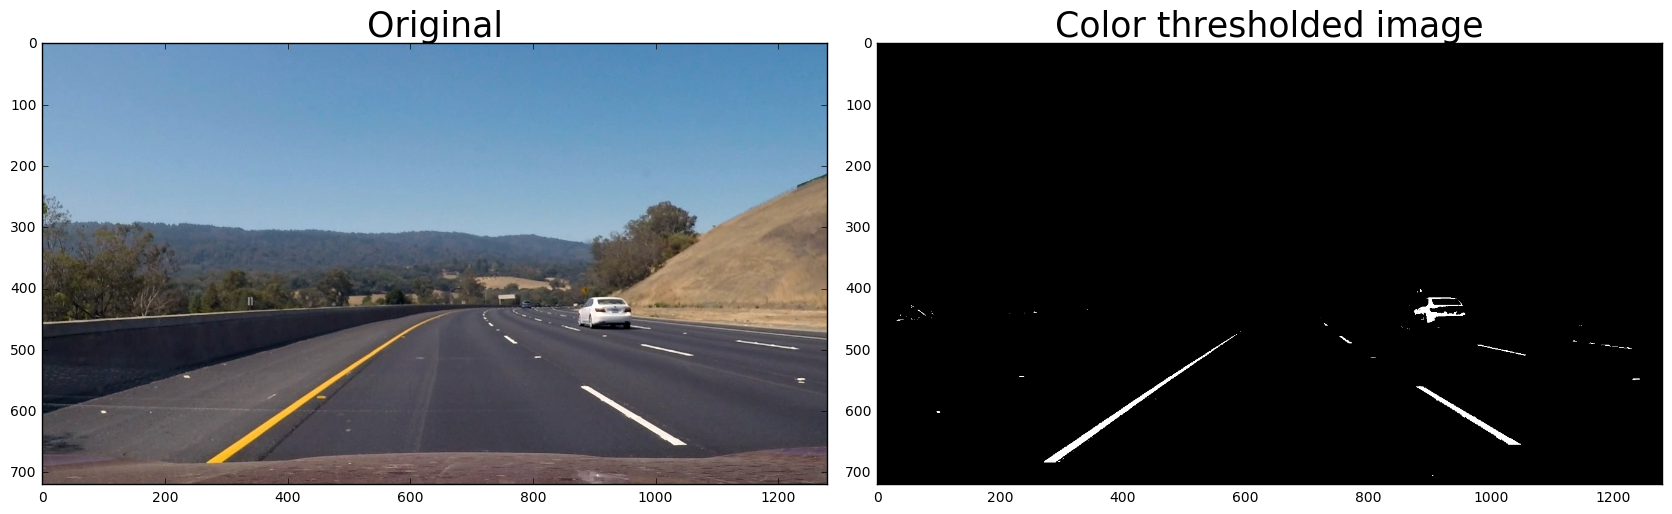

In [5]:
comb_color = color_threshold(image, h_thresh = (15,40), s_thresh=[200,255], l_thresh=(215,255))
show_image(image, comb_color, titles=['Original', 'Color thresholded image'], disp_flag = True)

The edge detected binary image and color thresholded binary image were then combined.

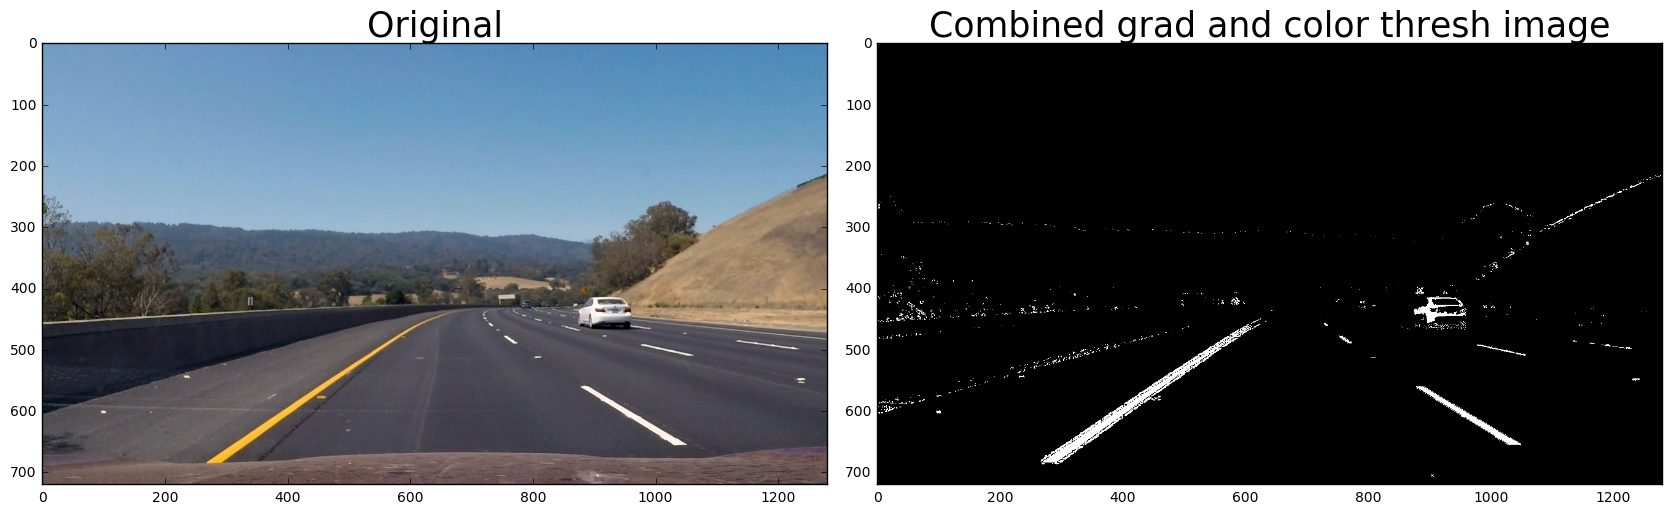

In [6]:
comb_grad_color, _ = combine_grad_color_thresh_images(combined_grad_binary, comb_color)
show_image(image, comb_grad_color, titles=['Original', 'Combined grad and color thresh image'], disp_flag=True)

## Perspective transform: 

Applying a perspective transform to the binary image above has two effects. It transforms the image to a 'birds-eye-view' or top down view which enables us to perform more sophisticated operations (eg. polynomial fit) that would otherwise be hard. It also enables us to discard much of the non-desirable regions in the image (eg. the trees, the horizon and other regions outside the lanes). The perspective transform is applied using the cv2.getPerspectiveTransform() which takes in source and destination points as arguments. The source points typically represent a trapezoidal region describing the road. The destination points represent a rectilinear region into which one would like to warp the trapezoidal road into. In my case, I chose 4 source points by visually inspecting a test image of the road. For the destination points I chose a rectilinear region with a horizontal offset of 300 pixels (from the left and right edges) and vertical offset of 100 pixels (from top and bottom edges). This resulted in the following set of points  

| Source points (x,y) | Destination points (x,y) |
|---------------------|--------------------------|
| 567, 466            | 300, 100                 |
| 718, 466            | 980, 100                 |
| 1008, 651           | 980, 620                 |
| 303, 651            | 300, 620                 |

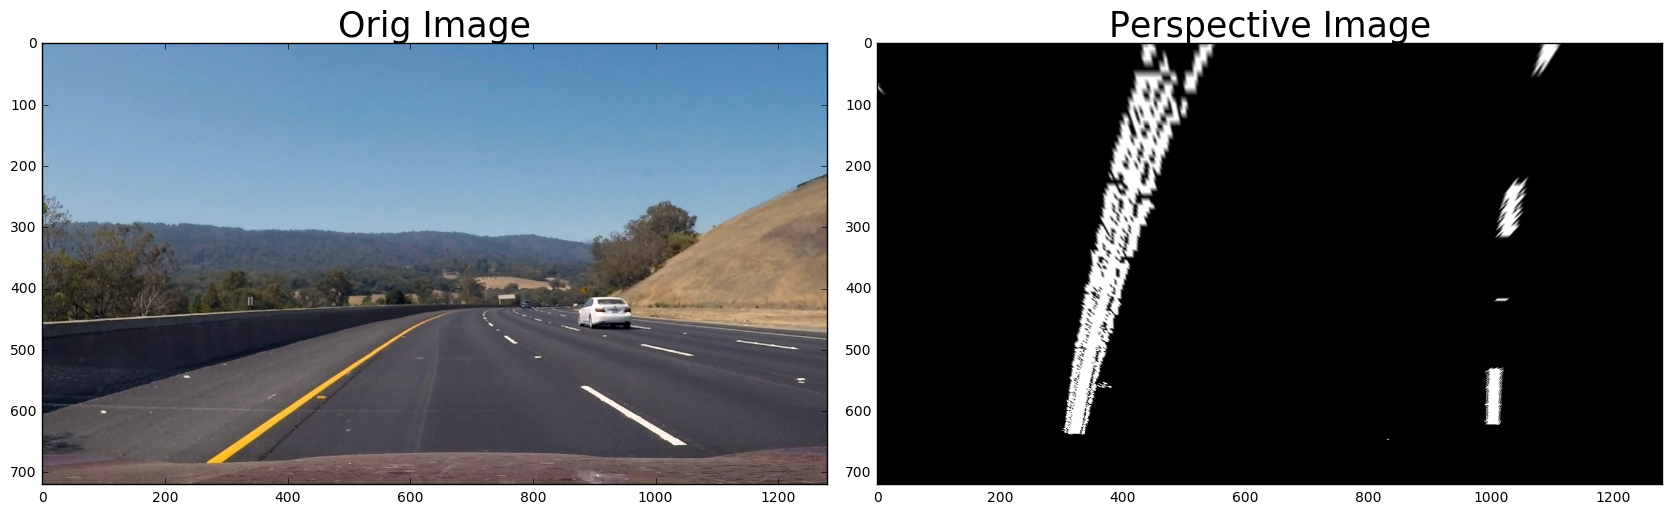

In [7]:
perspective_img, M, Minv = get_perspective_transform(comb_grad_color)
show_image(image, perspective_img, titles=['Orig Image', 'Perspective Image'], disp_flag=True)

# Processing

The goal of the processing steps is to cleanly detect the lane lines in the warped perspective image and then visualize the valid region between the lanes. I adopted the histogram / sliding window technique as described in the lectures with a few modifications that I will describe below.

The processing steps include histogram computation, polyfit computation using sliding windows and valid region visualization.
These steps are implemented in the class `ProcessFrame.py`. Each of these steps are described in detail below. 

## Histogram computation:

A histogram was computed by summing the pixels in the lower half of the pre-processed binary image. The idea here is that the peaks of the histogram should ideally correspond to the start of the lane line positions. This serves as the starting point for the sliding window technique described below. 

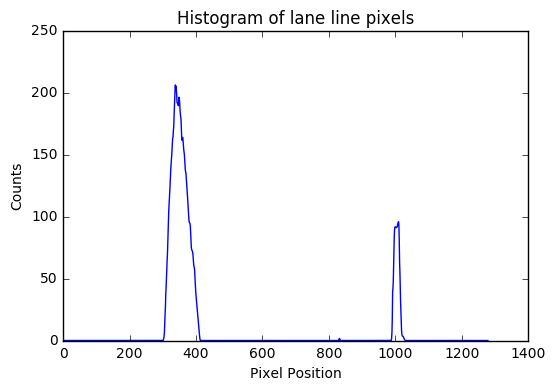

In [8]:
histogram = np.sum(perspective_img[int(perspective_img.shape[0]/2):,:], axis=0)
plt.title("Histogram of lane line pixels")
plt.xlabel("Pixel Position")
plt.ylabel("Counts")
plt.plot(histogram)

The histogram computation was enhanced to keep track of the top 3 peaks (for the left and right lanes). This was done to enable a fallback mode where if the top peak was wrong (for example due to excessive lighting, shadows, etc.) one could resort to the subsequent peaks.

## Polyfit computation using sliding windows:

The steps in this algorithm include
- Dividing the perspective image into 9 distinct windows of height 80 x 200 each for the left lane and the right lane.
- Using the pixel position values from histogram computation as the starting point to center the first window (one each for left and right lanes).
- Identify the non-zero pixels in this window and store it in a list
- Compute the mean of the non-zero pixels in the window and use that as a start point to center the next window (if there are atleast 50 non-zero pixels in the window). 
- Repeat the last two steps for all the 9 windows
- At the end of the loop one will have a list of valid positions for the left lane and a list of valid positions for the right lane.
- A polynomial of degree 2 is fit to these positions (using numpy polyfit) to calculate the polynomial co-efficients.

These steps are implemented in the get_best_fit_using_sliding_windows method

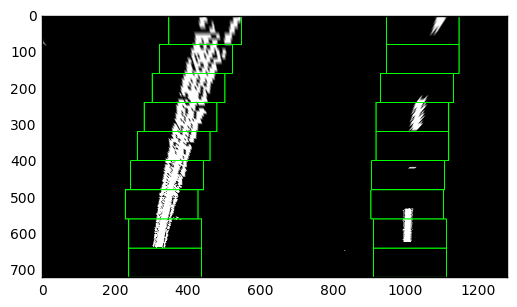

In [9]:
process_frame = ProcessFrame.ProcessFrame()
process_frame.debug = True
process_frame.get_best_fit_using_sliding_window(perspective_img)

Once the polynomial co-efficients are caclulated, it becomes relatively easy to compute and draw the lane lines by fitting a polynomial to a set of y indices as follows
``` python
ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
```


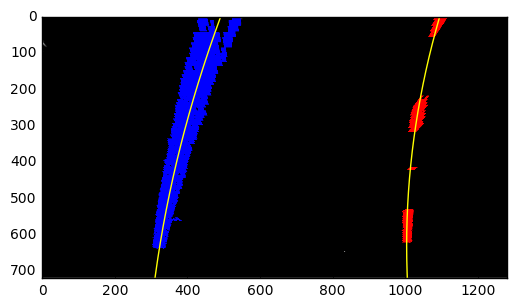

In [10]:
show_line_fit(perspective_img, process_frame.fit_dict)

A few other points about the algorithm
- Note that the sliding window mechanism explained above ideally needs to be applied only to the first frame of the video. The subsequent frames can be treated as one big window (each for the left lane and right lane) centered around the average lane position determined from the previous frame. This is achieved in the get_best_fit method.
- However there are instances where the frames may not be ideal (excessive lighting, shadows, etc.). So a fallback mechanism was implemented where the sliding window calculation gets activated if certain minimum number of non zero pixels (5000) are not detected.
- A running average scheme was implemented using a ring buffer to store the parameters of the last 10 frames and return the average values of these parameters on demand. This has the effect of smoothing out the outlier predictions and also reducing the jitters in the final video output. 

## Computing lane statistics

The following lane statistics were computed. The get_lane_statistics method in the ProcessFrame.py class does these calculations.

1. *Radius of curvature*
It becomes quite straightforward to compute the radius of curvature once the polynomial co-efficients are known. The polynomial co-efficients are plugged into the formula $(1 + (2Ay + B)^2)^{3/2} / 2A$. Care must be taken to convert the pixel co-ordinates to appropriate world dimensions in meters. For this purpose a lane length of 30 m  and lane width of 3.7 m was assumed in each frame.
2. *Vehicle offset from center*
This is computed assuming the midpoint at the bottom of the image corresponds to the center of the car (as it is the center of the camera). Then the left and right lane values are computed at the bottom of the image by fitting the max y value to the polynomial co-efficients. Like above, care must be taken to convert the pixel co-ordinates to appropriate world dimensions in meters. The avaerage of the left and right lane values gives the lane center position at the bottom of the image. Then the difference between the car center and lane center is calculated as the vehicle offset.

## Valid region visualization: 

This step involves unwarping the warped lane lines image and superimposing it on the original distorted image for visualization. The unwarping is done with the help of the inverse warp matrix (using cv2.warpPerspective) computed during the pre-processing stage. The implementation of this can be found in the draw_poly() method in the `visualize_images.py` script.

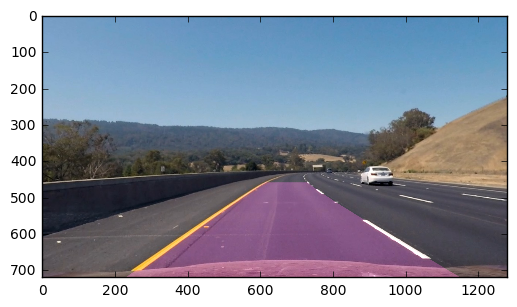

Left radius of curvature: 1012.6855321 mm
Right radius of curvature: 1012.6855321 mm
Vehicle offset: -0.0941784415283 mm


In [11]:
result = draw_poly(undist_img, perspective_img, Minv, process_frame.fit_dict, show_fig = True)
left_curve_rad, right_curve_rad, vehicle_offset = process_frame.compute_lane_statistics(perspective_img)
print("Left radius of curvature:", left_curve_rad, "mm")
print("Right radius of curvature:", left_curve_rad, "mm")
print("Vehicle offset:", vehicle_offset, "mm")